In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [313]:
class field():
    def __init__(self, ncells, bctype):
        self.nghost = 2
        self.ncells = ncells
        self.cc = np.zeros(ncells+self.nghost)
        self.cfVals_left = np.zeros(ncells+1)
        self.cfVals_right = np.zeros(ncells+1)
        self.derivative = np.zeros(ncells)
        self.a = np.zeros(ncells+1)
        self.ccVals = self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)]
        
        self.bc = bctype
        
    def setInitCond(self,f, vals):
        self.ccVals = f(vals)
        #self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] = self.ccVals
        
    def computeDerivative(self, dx, theta = 1.1):
        self.derivative =  (1.0/dx)*minmod((theta)*(self.cc[1:-1] - self.cc[0:-2]), \
                                  (0.5)*(self.cc[2:] - self.cc[:-2]), \
                                  (theta)*(self.cc[2:] - self.cc[1:-1]))
        
    def updateStuff(self):
        self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] = self.ccVals
        if (self.bc == 'periodic'):
            #self.setGhostCellValues(np.array([self.cc[1], self.cc[-2]]))
            self.cc[0] = self.cc[-2]
            self.cc[-1] = self.cc[1]
        #else:
        #    pass
        
    def setGhostCellValues(self, vals):
        if self.nghost == 2:
            self.cc[0] = vals[0]
            self.cc[-1] = vals[1]
        else:
            print('Changed number of ghost cells, update them!')

    def computeCellFaceValues(self, dx):
        self.computeDerivative(dx)
        self.cfVals_left[0] = self.cc[0]
        self.cfVals_left[1:] = self.ccVals + 0.5*dx*self.derivative
        self.cfVals_right[-1] = self.cc[-1]
        self.cfVals_right[:-1] = self.ccVals - 0.5*dx*self.derivative
        
    def computeFluxes(self, dx, fluxFn, fder):
        self.computeCellFaceValues(dx)
        
        self.a = computeLocalSpeed(self, fder)
        
        self.flux_jphalf = 0.5*(fluxFn(self.cfVals_right[1:]) + fluxFn(self.cfVals_left[1:]) \
                                - self.a[1:]*(self.cfVals_right[1:] - self.cfVals_left[1:]))
        
        self.flux_jmhalf = 0.5*(fluxFn(self.cfVals_right[:-1]) + fluxFn(self.cfVals_left[:-1]) \
                                - self.a[:-1]*(self.cfVals_right[:-1] - self.cfVals_left[:-1]))
        self.FinalFlux = -(self.flux_jphalf - self.flux_jmhalf)/dx
        
        
#------------------------------------------------------------------------------------------
class domain:
    def __init__(self, ncells, endpts):
        self.ncells = ncells
        self.xLeft = endpts[0]
        self.xRight = endpts[1]
        self.dx = (self.xRight - self.xLeft)/self.ncells
        self.x_cc = np.linspace(self.xLeft+self.dx, self.xRight-self.dx, ncells)
#-------------------------------------------------------------------------------------------
                
#-------------------------------------------------------------------------------------------
def minmod(a, b, c):
    result = np.zeros(len(a))
    overall = np.array([a, b, c])
    signs = np.prod(np.sign(overall),0)
    result[signs > 0] = np.amax(overall[:, signs > 0], 0)
    result[signs < 0] = np.amin(overall[:, signs < 0], 0)
    
    #zArr = np.zeros(a.shape)
    #result = np.amax(zArr, np.amin(,zArr,0),0)
    return result   
#-------------------------------------------------------------------------------------------
#def fluxFn(u):
#    return (0.5*u**2)

#-------------------------------------------------------------------------------------------
def computeLocalSpeed(u_field, fder):
    #This changes if the above function changes
    return np.amax(np.absolute(np.array([fder(u_field.cfVals_left), fder(u_field.cfVals_right)])),0)

##  Zero flux fn

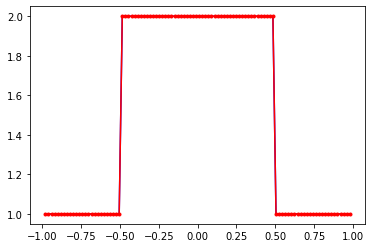

In [232]:
#Domain setup
x = domain(100, np.array([-1,1]))
fluxFn = lambda u: np.zeros(u.shape)
fluxFnDer = lambda u: np.zeros(u.shape)

#Field setup
u = field(x.ncells, 'periodic')
utemp = field(x.ncells, 'periodic')

#Initial conditions
initC = lambda x: 1.0*(x < 0.5) + 1.0*(x > -0.5)
u.setInitCond(initC, x.x_cc)
u.updateStuff()

utemp.setInitCond(initC, x.x_cc)
utemp.updateStuff()


plt.figure()
t = 0.0
tFinal = 1.0
dt = 0.02
plt.plot(x.x_cc, u.ccVals,'b')
while t < tFinal:
    #print("Time:",t)
    
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    u.ccVals = u.ccVals + 0.5*dt*(u.FinalFlux + utemp.FinalFlux)
    #u.ccVals = u.ccVals + dt*(u.FinalFlux)
    u.updateStuff()
    utemp.cc = u.cc
    
    #Lax-Friedrichs scheme
    #uLxF[1:-1] = 0.5*(uLxF[2:] + uLxF[:-2]) - 0.5*(dt/dx)*(fluxFn(uLxF[2:]) - fluxFn(uLxF[:-2]))
    t = t + dt
plt.plot(x.x_cc, u.ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()

In [233]:
u.derivative

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Simple advection

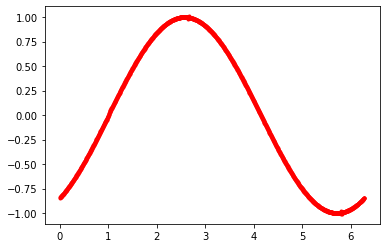

0.0014082758651848735


In [326]:
#Domain setup
Ncells = 1280
x = domain(Ncells, np.array([0,2*np.pi]))
fluxFn = lambda u: u
fluxFnDer = lambda u: np.ones(u.shape)

#Field setup
u = field(x.ncells, 'periodic')
utemp = field(x.ncells, 'periodic')

#Initial conditions
initC = lambda x: np.sin(x)
u.setInitCond(initC, x.x_cc)
u.updateStuff()

utemp.setInitCond(initC, x.x_cc)
utemp.updateStuff()

plt.figure()
t = 0.0
tFinal = 1.0
dt = 0.0005#x.dx*0.125*np.amax(fluxFnDer(initC(x.x_cc)))
plt.plot(x.x_cc, initC(x.x_cc - tFinal),'b')
while t <= tFinal:
    #print("Time:",t)
    
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    u.ccVals = u.ccVals + 0.5*dt*(u.FinalFlux + utemp.FinalFlux)
    #u.ccVals = u.ccVals + dt*(u.FinalFlux)
    u.updateStuff()
    utemp.cc = u.cc
    
    #Lax-Friedrichs scheme
    #uLxF[1:-1] = 0.5*(uLxF[2:] + uLxF[:-2]) - 0.5*(dt/dx)*(fluxFn(uLxF[2:]) - fluxFn(uLxF[:-2]))
    t = t + dt
plt.plot(x.x_cc, u.ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()
print(np.linalg.norm(initC(x.x_cc - tFinal) - u.ccVals, 1)/Ncells)

In [327]:
N = np.array([40, 80, 160, 320, 640, 1280])
error = np.array([0.04774797771975571, 0.02326790064023887, 0.011349526753112137, 0.005522122846255559, \
                  0.0026656065333788494, 0.0014082758651848735])

orderSlope = np.log2(1./np.diff(N))/np.log2(abs(np.diff(error)))
orderSlope

array([0.99433509, 0.98924359, 0.98639313, 0.98466556, 0.96746462])

## Burgers equation (How do I get the exact solution?- not the expansiony expression)

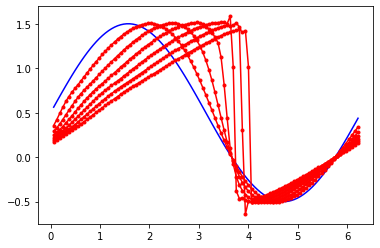

In [307]:
#Domain setup
x = domain(101, np.array([0.0,2.0*np.pi]))
fluxFn = lambda u: 0.5*u**2
fluxFnDer = lambda u: u

#Field setup
u = field(x.ncells,'periodic')
utemp = field(x.ncells,'periodic')

#Initial conditions
initC = lambda x: 0.5 + np.sin(x)#np.exp(-(x - np.pi)**2/0.8)
u.setInitCond(initC, x.x_cc)
u.updateStuff()

utemp.setInitCond(initC, x.x_cc)
utemp.updateStuff()


plt.figure()
t = 0.0
tFinal = 2.0
it = 0
dt = x.dx*0.125*np.amax(fluxFnDer(initC(x.x_cc)))
plt.plot(x.x_cc, u.ccVals,'b')
while t <= tFinal:
    #print("Time:",t)
    
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    u.ccVals = u.ccVals + 0.5*dt*(u.FinalFlux + utemp.FinalFlux)
    #u.ccVals = u.ccVals + dt*(u.FinalFlux)
    u.updateStuff()
    utemp.cc = u.cc
    
    #Lax-Friedrichs scheme
    #uLxF[1:-1] = 0.5*(uLxF[2:] + uLxF[:-2]) - 0.5*(dt/dx)*(fluxFn(uLxF[2:]) - fluxFn(uLxF[:-2]))
    t = t + dt
    it = it + 1
    if np.mod(it, 25) < 1e-10:
        plt.plot(x.x_cc, u.ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()

## Non-convex flux

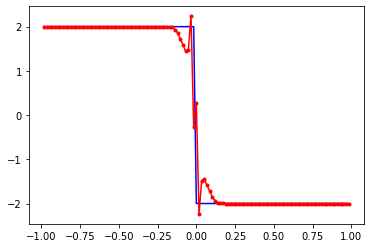

In [312]:
#Domain setup
x = domain(115, np.array([-1.0, 1.0]))
fluxFn = lambda u: 0.25*((u**2 - 1.0)*(u**2 - 4.0))
fluxFnDer = lambda u: 0.5*u*(2*u**2 - 5.0)

#Field setup
u = field(x.ncells,'dir')
utemp = field(x.ncells,'dir')

#Initial conditions
initC = lambda x: 2.0*(x < 0.0) + (-2.0*(x > 0.0))
u.setInitCond(initC, x.x_cc)
u.setGhostCellValues(np.array([2.0,-2.0]))

utemp.setInitCond(initC, x.x_cc)
utemp.setGhostCellValues(np.array([2.0,-2.0]))


plt.figure()
t = 0.0
tFinal = 0.5
dt = 0.0001#x.dx*0.125*np.amax(fluxFnDer(initC(x.x_cc)))
plt.plot(x.x_cc, u.ccVals,'b')
while t < tFinal:
    #print("Time:",t)
    
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    utemp.ccVals = utemp.ccVals + dt*utemp.FinalFlux
    utemp.updateStuff()
    utemp.computeFluxes(x.dx, fluxFn, fluxFnDer)
    
    u.ccVals = u.ccVals + 0.5*dt*(u.FinalFlux + utemp.FinalFlux)
    #u.ccVals = u.ccVals + dt*(u.FinalFlux)
    u.updateStuff()
    utemp.cc = u.cc
    #print(np.linalg.norm(u.FinalFlux,np.inf))
    #Lax-Friedrichs scheme
    #uLxF[1:-1] = 0.5*(uLxF[2:] + uLxF[:-2]) - 0.5*(dt/dx)*(fluxFn(uLxF[2:]) - fluxFn(uLxF[:-2]))
    t = t + dt
    #if t > 100*dt:
    #    break
    #if np.mod(1./t,100.0) == 0:
plt.plot(x.x_cc, u.ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()

In [251]:
test = 0.5*(fluxFn(u.cfVals_right) + fluxFn(u.cfVals_left))-u.a*(u.cfVals_left-u.cfVals_right)

In [253]:
test[1:] - test[:-1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.48743980e-06,  5.70958613e-03, -1.12910086e-02,  9.23562359e-01,
        2.39147628e+01, -2.38327453e+01,  2.38327453e+01, -2.39147628e+01,
       -9.23562359e-01,  